In [1]:
import asyncio
import os
import textwrap

import json
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from funman import Funman
from funman.funman import FUNMANConfig
from funman.model import QueryLE
from funman.model.bilayer import BilayerDynamics, BilayerGraph, BilayerModel
from funman.model.query import QueryEncoded, QueryTrue
from funman.scenario import ConsistencyScenario, ConsistencyScenarioResult
from funman.scenario.scenario import AnalysisScenario

# From openapi-python-client
from funman_api_client import Client
from funman_api_client.api.default import (        
    solve_consistency_solve_consistency_put,                             
)                                                                                     
from funman_api_client.models import (
    BodySolveConsistencySolveConsistencyPut,                     
    ConsistencyScenario,                                                 
    ConsistencyScenarioResult,                                                                                                
)

In [2]:
RESOURCES = "../resources"
API_SERVER_HOST = "127.0.0.1"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
# OPENAPI_URL = f"{SERVER_URL}/openapi.json"
# CLIENT_NAME = "funman-api-client"

funman_client = Client(SERVER_URL, timeout=None)

In [3]:
def report(result, iteration, results_df):
    if result.consistent:
        parameters = result.response_parameters.to_dict()
        print(f"Iteration {iteration}: {parameters}")

        res = pd.Series(name=iteration, data=parameters).to_frame().T
        results_df = pd.concat([results_df, res])

        df = pd.DataFrame.from_dict(result.response_timeseries.to_dict())
        df = df.interpolate(method="linear")
        print(df)

        variables = ["S", "E", "I", "R"]
        #plt.show(block=False)
        df[variables].plot(
            marker="o",
            title="\n".join(textwrap.wrap(str(parameters), width=75)),
        )
        plt.show()
        #plt.savefig(f"bilayer_cc_{iteration}.png")
        plt.clf()
    else:
        print(f"Iteration {iteration}: is inconsistent")
        
results_df = pd.DataFrame()
iteration = 0

In [10]:
bilayer_path = os.path.join(RESOURCES, "bilayer", "SEIRD_bilayer_handcoded.json")
with open(bilayer_path, "r") as bl:
    bilayer_json = json.load(bl)

infected_threshold = 130e3

# initial state
N0 = 500e3              
E0, I0, R0 = 100, 1, 0    
S0 = N0 - E0 - I0       
init_values = {"S": S0, "E": E0, "I": I0, "R": R0, "D": 0} 

# bounds
default_bounds = [1e-3, 0.35]
parameter_bounds = {                                                                   
    "mu_s": default_bounds,                                                  
    "mu_e": default_bounds,                                                  
    "mu_i": default_bounds,                                                   
    "mu_r": default_bounds,                                                    
    "beta_1": default_bounds,                        
    "epsilon": default_bounds,                             
    "alpha": default_bounds,                            
    "gamma": default_bounds,                                               
}         

# identical parameters
identical_parameters = [["mu_s", "mu_e", "mu_i", "mu_r"]]

In [11]:
response = await solve_consistency_solve_consistency_put.asyncio_detailed(
        client=funman_client,
        json_body=BodySolveConsistencySolveConsistencyPut(
            ConsistencyScenario.from_dict({
                "model": {
                    "init_values": init_values,
                    "parameter_bounds": parameter_bounds,
                    "identical_parameters": identical_parameters,
                    "bilayer": {"json_graph": bilayer_json},
                },
                "query": {    
                    "variable": "I",
                    "ub": infected_threshold,
                    "at_end": False,
                },
            })
        )
    )
result = ConsistencyScenarioResult.from_dict(    
    src_dict=json.loads(response.content.decode())    
)

Iteration 2: {'beta_1': 0.0010013897807357086, 'gamma': 0.09375, 'mu_s': 0.25, 'mu_e': 0.25, 'mu_i': 0.25, 'mu_r': 0.25, 'alpha': 0.25, 'epsilon': 0.3359375}
   index              S             E           I         R            D
0    0.0  499899.000000    100.000000    1.000000  0.000000       0.0000
1    1.0  374423.656250    542.000000   34.000000  0.093750  125000.2500
2    2.0  268069.645404  12972.518658  195.890625  3.257812  218758.6875


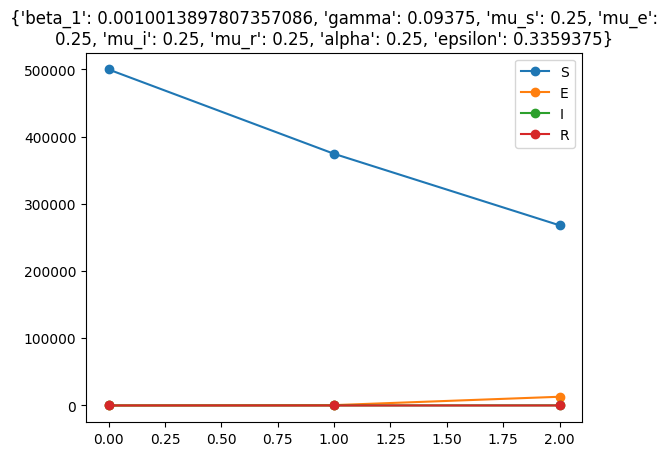

<Figure size 640x480 with 0 Axes>

In [12]:
report(result, iteration, results_df)
iteration += 1